# **PREDICTION OF SATELLITE IMAGERY USING SMOOTH BLENDING**

## **Sources and References**
1. https://github.com/Vooban/Smoothly-Blend-Image-Patches
2. https://github.com/bnsreenu/python_for_microscopists/tree/master/229_smooth_predictions_by_blending_patches

## **Import Library and Initialize Parameter**

In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing
# from simple_multi_unet_model import jacard_coef

# size of patches
patch_size = 256

# Number of classes 
n_classes = 6

Segmentation Models: using `keras` framework.


## **Load Image**

In [2]:
img = cv2.imread("drone/0001-min.jpg", 1)
original_mask = cv2.imread("Semantic segmentation dataset\Tile 4\masks\image_part_008.png", 1)
original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)

## **Load Model**

In [3]:
from keras.models import load_model
model = load_model("models/satellite_unet_100epochs_6Oct2021.hdf5",compile=False)

## **Prediction Without Smooth Blending**

In [4]:
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)     


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

(-0.5, 5375.5, 3583.5, -0.5)

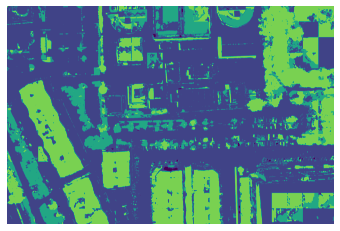

In [5]:
# Unpatch the image
unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

# Show image
plt.imshow(unpatched_prediction)
plt.axis('off')

## **Prediction With Smooth Blending**

In [6]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

  0%|          | 0/8 [27:09<?, ?it/s]


MemoryError: Unable to allocate 3.65 GiB for an array with shape (1247, 256, 256, 6) and data type float64

## **Convert Labeled Images back to Original RGB Colored Masks**

In [7]:
def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

## **Plot Results**

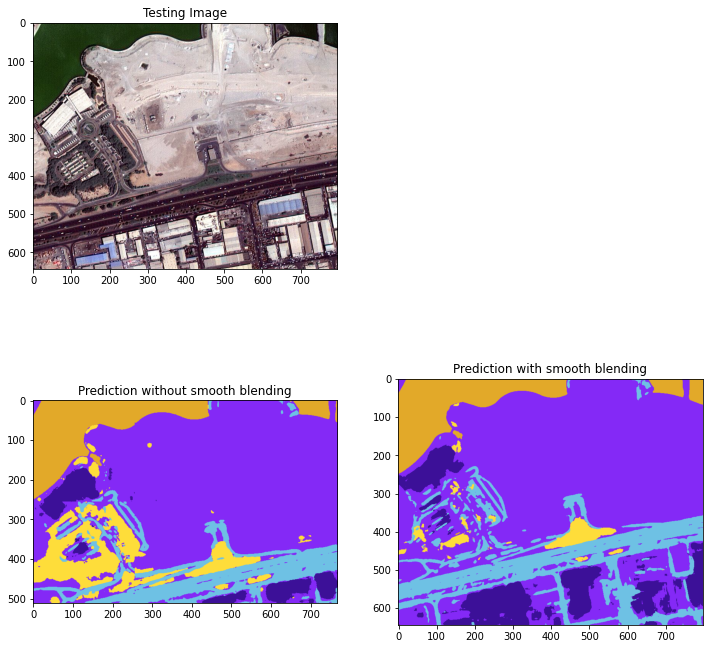

In [8]:
prediction_with_smooth_blending=label_to_rgb(final_prediction)
prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
#plt.subplot(222)
# plt.title('Testing Label')
# plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()